# Kaggle Titanic competition
goal: create fast and submit to learn how to deal with Kaggle


In [1]:
# general & data analysis imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing imports
from sklearn import preprocessing
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# model learning & evaluation imports
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

## data loading

In [2]:
train_dataset=pd.read_csv('train.csv')
test_dataset=pd.read_csv('test.csv')

## data analysis

In [ ]:
train_dataset.info()

In [ ]:
train_dataset.describe()

In [ ]:
train_dataset.head()


In [ ]:
train_dataset.hist(figsize=(15,20));
plt.figure();

In [ ]:
sns.pairplot(train_dataset, hue="Survived");

In [ ]:
sns.heatmap(train_dataset.corr(),annot=True) 


In [ ]:
test_dataset.isnull().sum()

## data preprocessing

In [3]:
# remove dependent variable from train set to have the same structure as test set
df_y=train_dataset['Survived'].copy()
train_dataset.drop('Survived', axis=1,inplace=True)

In [4]:
def preprocess_data(source_df):
    df=source_df.copy()
    # Age to bins, NaN to separate bin
    df.Age.fillna(-1, inplace=True)
    age_bins=(-10,0,14,40,500)
    age_labels=('unk','upto14','age_upto40','above40')
    df.Age=pd.cut(df.Age, age_bins, labels=age_labels)
    #cabin - keep first letter
    df.Cabin.fillna('Unknown', inplace=True)
    df.Cabin=df.Cabin.apply(lambda x: x[0])
    # fare - divide by mean (~32)
    df.Fare.fillna(df.Fare.median(), inplace=True)
    df.Fare=df.Fare.apply(lambda x: x/32)
    # embarked - fillna
    df.Embarked.fillna('U', inplace=True)
    # ticket, name - drop
    df=df.drop(['Ticket','Name'], axis=1)
    # SibSp, Parch - replace to binary
    df.SibSp=df.SibSp.apply(lambda x: int(x>0))
    df.Parch=df.Parch.apply(lambda x: int(x>0))
    
    #return preprocessed df
    return df


In [5]:
df_test=preprocess_data(test_dataset)
df_train=preprocess_data(train_dataset)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null category
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 56.8+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null category
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 26.8+ KB


In [8]:
def encode(df1, df2):
    '''df1, df2 - train and test dataframes
    return - modified df1, df2'''
    
    cat_features =['Sex','Pclass'] # features for categorization
    onehot_features=['Cabin','Embarked','Age'] # features for onehot encoding
    
    # for each feature, use LabelEncoder on both dataframes
    for f in cat_features:
        l_encoder = preprocessing.LabelEncoder()
        l_encoder.fit(df1[f])
        df1[f]=l_encoder.transform(df1[f])
        df2[f]=l_encoder.transform(df2[f])

    # use OneHotEncoder on both dataframes
    oh_encoder = ce.OneHotEncoder(handle_unknown='ignore', cols=onehot_features,use_cat_names=True)
    df1=oh_encoder.fit_transform(df1)
    df2=oh_encoder.transform(df2)
    
    return df1,df2
        
    

In [9]:
df_train, df_test = encode(df_train, df_test)

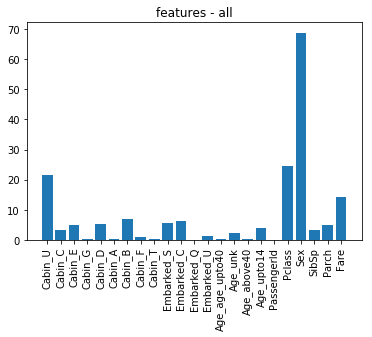

removed worst: Embarked_Q, p=0.9133532352434973
removed worst: PassengerId, p=0.8813657768795535
removed worst: Age_age_upto40, p=0.671318948553247
removed worst: Age_above40, p=0.6358060234148096
removed worst: Cabin_G, p=0.6325420044333476
removed worst: Cabin_A, p=0.5064306274592466
removed worst: Cabin_T, p=0.43026102541672473


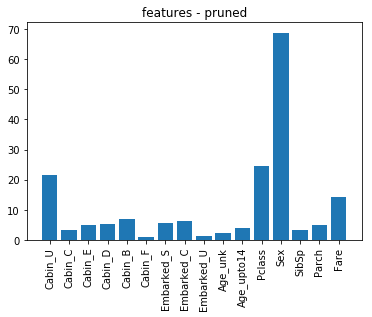

In [10]:
# Perform feature selection
#draw a graph before
predictors=df_train.columns.tolist()
selector = SelectKBest(f_classif, k='all')
_=selector.fit(df_train, df_y)
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.title('features - all')
plt.show()

#iterative pruning of least important feature
K=16  # final number of features
X_train_pruned = df_train.values
X_test_pruned= df_test.values
for i in range(len(predictors),K,-1):
    predictors=df_train.columns.tolist()
    selector = SelectKBest(f_classif, k='all')
    _ = selector.fit(df_train, df_y)
    # find the worst feature
    worst=np.argmax(selector.pvalues_)
    # drop this feature from train and test set
    df_train.drop(predictors[worst], axis=1, inplace=True)
    df_test.drop(predictors[worst], axis=1, inplace=True)
    print(f'removed worst: {predictors[worst]}, p={selector.pvalues_[worst]}')
#   
X_train_pruned=df_train.values
X_test_pruned=df_test.values

#draw a graph after
predictors=df_train.columns.tolist()
selector = SelectKBest(f_classif, k='all')
_=selector.fit(df_train, df_y)
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.title('features - pruned')
plt.show()

In [ ]:
X_train_pruned.shape

## building MLP model

In [ ]:
# split train and validation
# X_train,X_val,y_train,y_val=train_test_split(df_train.values,dfy.values,test_size=0.25,random_state=1, shuffle=True)
X_train,X_val,y_train,y_val=train_test_split(X_train_pruned,df_y.values,test_size=0.15,random_state=1, shuffle=True)
X_test=X_test_pruned

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

In [ ]:
def mlp_model(units_list, l2=0, dropout_rate=0):
    model=models.Sequential()
    for u in units_list:
        model.add(Dense(units=u, activation='relu',kernel_regularizer=regularizers.l2(l2)))
        if dropout_rate>0:
            model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [ ]:
def train_model(model,data,epochs=20,learning_rate=1e-3):
    
    X_train, y_train, X_val, y_val = data
    # Compile model with learning parameters.
    loss = 'binary_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in <patience> consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20)]

    # Train and validate model.
    history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
    #        callbacks=callbacks,
            validation_data=(X_val, y_val),
            verbose=2,  # Logs once per epoch.
            batch_size=128)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Plot training & validation accuracy values
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Save model.
    # model.save('titanic.h5')
    return history['val_acc'][-1], history['val_loss'][-1], model

In [ ]:
my_model=mlp_model(units_list=[8,8,6,4],l2=0.006,dropout_rate=0.)

In [ ]:
my_data= (X_train, y_train, X_val, y_val)
_,_,my_model=train_model(my_model,my_data,epochs=1000,learning_rate=3e-4)

## predict for test data & submit

In [ ]:
y_probs=my_model.predict(X_test)
y_preds=np.rint(y_probs).astype(int)
y_preds=y_preds.reshape(-1)

In [ ]:
submission = pd.DataFrame({'PassengerId':test_dataset['PassengerId'],'Survived':y_preds})


In [ ]:
submission.to_csv('submission.csv',index=False)